In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('axes', titlesize=23, labelsize=20)
plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18)
plt.rc('legend', fontsize=18)

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, auc, log_loss
from scipy.special import expit
from scipy import interpolate
from scipy import integrate
from collections import Counter

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))

import warnings
warnings.filterwarnings('default')

import src.visualization as viz
import src.simulation as sim

/Users/nswinger/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)


In [2]:
from datetime import datetime
import plotly.express as px
from scipy.stats import sem

from src.abroca import compute_abroca, abroca_from_predictions
from src.simulation import simulate, SimulationParams


def regress(X, y, n, p_0, regressor_type='logistic'):
    n_0 = int(round(n * p_0))
    X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(X[:n_0], y[:n_0], test_size=0.2, random_state=0)
    X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X[n_0:], y[n_0:], test_size=0.2, random_state=0)

    if len(set(y_test_0)) == 1 or len(set(y_test_1)) == 1:
        return

    X_train = np.append(X_train_0, X_train_1, axis=0)
    y_train = np.append(y_train_0, y_train_1, axis=0)

    if len(set(y_train)) == 1:
        return
    if regressor_type == 'randomforest':
        regressor = RandomForestRegressor(n_estimators = 10, random_state=0)
    elif regressor_type == 'mlpclassifier':
        regressor = MLPClassifier(hidden_layer_sizes=(32,32), learning_rate_init=1e-4, batch_size=128, max_iter=200, random_state=0)
    elif regressor_type == 'logistic':
        regressor = LogisticRegression(solver='lbfgs')
    else:
        regressor = LogisticRegression(solver='lbfgs')
#         regressor = LogisticRegressionCV(cv=5)
    perm = np.random.permutation(len(y_train))
    regressor.fit(X_train[perm], y_train[perm])
    
    return regressor, X_test_0, X_test_1, y_test_0, y_test_1


def evaluate(regressor, X_test_0, X_test_1, y_test_0, y_test_1):
    if len(set(y_test_0)) == 1 or len(set(y_test_1)) == 1:
        return

    y_pred_0 = regressor.predict(X_test_0)
    y_pred_1 = regressor.predict(X_test_1)

    fpr_0, tpr_0, _ = roc_curve(y_test_0, y_pred_0)
    fpr_1, tpr_1, _ = roc_curve(y_test_1, y_pred_1)

    g0auc = auc(fpr_0, tpr_0)
    g1auc = auc(fpr_1, tpr_1)
    abroca = compute_abroca(fpr_0, tpr_0, fpr_1, tpr_1)

    return fpr_0, tpr_0, fpr_1, tpr_1, g0auc, g1auc, abroca


def ABROCAvs_plot_new(plot_type, versus, r=10, s=0, both=False, reg_type='logistic', **kwargs):
    """Generates mean ABROCA values and standard errors that are necessary for creating 'ABROCA vs Change in Simulation Parameter' plots.

    Args:
        plot_type (str): Chooses which simulation parameter to manipulate. Options are 'n', 'p_0', 'mu_orthogonal', 'mu_parallel', 'obs_noise', 'theta_diff'.
        versus (np.ndarray[float]): Varied values of some simulation parameter which is used in calculation of ABROCA.
        r (int): Number of trials of ABROCA calculation, each with a new randomly simulated dataset based on same simulation parameters.
        s (int): Random seed.
        both (boolean): Chooses between rotating or rescaling theta_1. If true, rescaling occurs, if false, rotation occurs.
        reg_type (string): Choose type of classifier. Options are 'logistic', 'mlpclassifier', or 'randomforest'.
        **kwargs: Passed to SimulationParams.

    Returns:
        A tuple (avg_abrocas, errors, avg_g0_aucs, avg_g1_aucs), where 'avg_abrocas' is an array of values for each set of simulation parameters, with each value being the mean ABROCA score over 'r' trials, and 'errors' is a similar array, but with standard errors instead of means. 'avg_g0_aucs' and 'avg_g1_aucs' are constructed in a similar manner as well, but contain average auc values for their respective groups rather than ABROCA.
    """

    np.random.seed(s)
    avg_abrocas = None
    avg_g0_aucs = None
    avg_g1_aucs = None
    
    for i in range(r):
        abrocas = [np.nan for _ in range(len(versus))]
        g0_aucs = [np.nan for _ in range(len(versus))]
        g1_aucs = [np.nan for _ in range(len(versus))]
        dflts = SimulationParams()
        X_train, y_train = simulate(dflts)
        reg = regress(X_train, y_train, dflts.n, dflts.p_0, regressor_type=reg_type)
        if reg is None:
            continue

        for j, e in enumerate(versus):
            if plot_type == 'p_0':
                kwargs['p_0'] = e
            elif plot_type == 'mu_orthogonal':
                kwargs['mu_change'], kwargs['orthog_to_boundary'] = e, True
            elif plot_type == 'mu_parallel':
                kwargs['mu_change'] = e
            elif plot_type == 'obs_noise':
                kwargs['eta_sd'] = [.1, e]
            elif plot_type == 'theta_diff':
                if both:
                    kwargs['theta_1'] = [1 * e * 4, 1 * e * 4]
                else:
                    kwargs['theta_1'] = [(2**0.5)*np.cos(e*.6*np.pi), (2**0.5)*np.sin(e*.6*np.pi)]
            elif plot_type == 'n':
                kwargs['n'] = e

            dflts_shifted = SimulationParams(**kwargs)
            X, y = simulate(dflts_shifted)
            n_0 = int(round(dflts_shifted.n * dflts_shifted.p_0))
            _, X_test_0, _, y_test_0 = train_test_split(X[:n_0], y[:n_0], test_size=0.2, random_state=0)
            _, X_test_1, _, y_test_1 = train_test_split(X[n_0:], y[n_0:], test_size=0.2, random_state=0)

            stats = evaluate(reg[0], X_test_0, X_test_1, y_test_0, y_test_1)
            if stats is None:
                continue

            abrocas[j] = stats[6]
            g0_aucs[j] = stats[4]
            g1_aucs[j] = stats[5]
            
        if avg_abrocas is None:
            avg_abrocas = np.array(abrocas).reshape((-1, 1))
        else:
            avg_abrocas = np.append(avg_abrocas, np.array(abrocas).reshape((-1, 1)), axis=1)
        if avg_g0_aucs is None:
            avg_g0_aucs = np.array(g0_aucs).reshape((-1, 1))
        else:
            avg_g0_aucs = np.append(avg_g0_aucs, np.array(g0_aucs).reshape((-1, 1)), axis=1)
        if avg_g1_aucs is None:
            avg_g1_aucs = np.array(g1_aucs).reshape((-1, 1))
        else:
            avg_g1_aucs = np.append(avg_g1_aucs, np.array(g1_aucs).reshape((-1, 1)), axis=1)

    errors = sem(avg_abrocas, axis=1, nan_policy='omit').reshape(-1)
    avg_abrocas = np.nanmean(avg_abrocas, axis=1).ravel()
    avg_g0_aucs = np.nanmean(avg_g0_aucs, axis=1).ravel()
    avg_g1_aucs = np.nanmean(avg_g1_aucs, axis=1).ravel()

    return avg_abrocas, errors, avg_g0_aucs, avg_g1_aucs

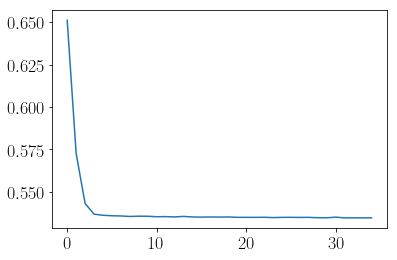

In [60]:
plt.plot(regressor.loss_curve_)

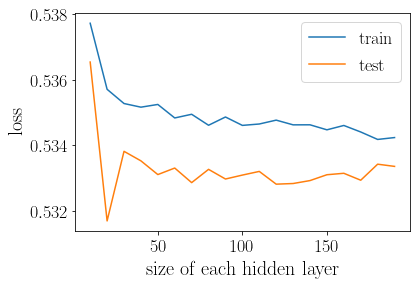

In [54]:
dflts = SimulationParams()
X, y = simulate(dflts)

n_0 = int(round(dflts.n * dflts.p_0))
X_train_0, _, y_train_0, _ = train_test_split(X[:n_0], y[:n_0], test_size=0.2, random_state=0)
X_train_1, _, y_train_1, _ = train_test_split(X[n_0:], y[n_0:], test_size=0.2, random_state=0)
X_train = np.append(X_train_0, X_train_1, axis=0)
y_train = np.append(y_train_0, y_train_1, axis=0)

dflts_shifted = SimulationParams() # shift parameters here
X, y = simulate(dflts_shifted)

n_0 = int(round(dflts_shifted.n * dflts_shifted.p_0))
_, X_test_0, _, y_test_0 = train_test_split(X[:n_0], y[:n_0], test_size=0.2, random_state=0)
_, X_test_1, _, y_test_1 = train_test_split(X[n_0:], y[n_0:], test_size=0.2, random_state=0)
X_test = np.append(X_test_0, X_test_1, axis=0)
y_test = np.append(y_test_0, y_test_1, axis=0)

hidden_units = np.arange(10,200,10)
regressor = MLPClassifier(learning_rate_init=1e-4, batch_size=128, max_iter=200, random_state=0)

train_losses = list()
test_losses = list()
for hidden_unit in hidden_units:
    regressor.set_params(hidden_layer_sizes=(hidden_unit, hidden_unit))
    regressor.fit(X_train, y_train)
    train_losses.append(log_loss(y_train, regressor.predict_proba(X_train)))
    test_losses.append(log_loss(y_test, regressor.predict_proba(X_test)))
    

plt.plot(hidden_units, train_losses, label='train')
plt.plot(hidden_units, test_losses, label='test')
plt.xlabel('size of each hidden layer')
plt.ylabel('loss')
plt.legend()
plt.show()

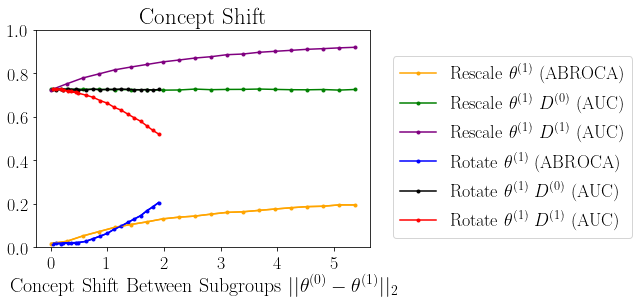

In [16]:
# theta difference vs. ABROCA plot example
theta_scale = np.arange(.25,1.25,0.05)
n = 10000
r = 100
s = 7
title = 'Concept Shift'
plt.xscale('linear')
plt.yscale('linear')

both = True
avg_abrocas, errors, avg_g0_aucs, avg_g1_aucs = ABROCAvs_plot_new('theta_diff', theta_scale, s=s, n=n, r=r, both=both, reg_type='logistic')
theta_diff_mag = [np.linalg.norm(np.array([[1*e*4,1*e*4]]) - np.array([[1,1]]), ord=2) for e in theta_scale]
plt.plot(theta_diff_mag, avg_abrocas, marker='.', color='orange', label=r'Rescale $\theta^{(1)}$ (ABROCA)')
plt.errorbar(theta_diff_mag, avg_abrocas, yerr=2*errors, color='orange')
plt.plot(theta_diff_mag, avg_g0_aucs, marker='.', color='green', label=r'Rescale $\theta^{(1)}$ $D^{(0)}$ (AUC)')
plt.plot(theta_diff_mag, avg_g1_aucs, marker='.', color='purple', label=r'Rescale $\theta^{(1)}$ $D^{(1)}$ (AUC)')

both = False
avg_abrocas, errors, avg_g0_aucs, avg_g1_aucs = ABROCAvs_plot_new('theta_diff', theta_scale, s=s, n=n, r=r, both=both, reg_type='logistic')
theta_diff_rot = [np.linalg.norm(np.array([[(2**0.5)*np.cos(e*.6*np.pi), (2**0.5)*np.sin(e*.6*np.pi)]]) - np.array([[1,1]]), ord=2) for e in theta_scale]
plt.plot(theta_diff_rot, avg_abrocas, marker='.', color='blue', label=r'Rotate $\theta^{(1)}$ (ABROCA)')
plt.errorbar(theta_diff_rot, avg_abrocas, yerr=2*errors, color='blue')
plt.plot(theta_diff_rot, avg_g0_aucs, marker='.', color='black', label=r'Rotate $\theta^{(1)}$ $D^{(0)}$ (AUC)')
plt.plot(theta_diff_rot, avg_g1_aucs, marker='.', color='red', label=r'Rotate $\theta^{(1)}$ $D^{(1)}$ (AUC)')

plt.xlabel(r'Concept Shift Between Subgroups $||\theta^{(0)} - \theta^{(1)} ||_2$')
# plt.ylabel('ABROCA')
plt.ylim([0,1])
plt.title(title)
plt.legend(bbox_to_anchor=(1.04,0), loc="lower left")
# plt.legend()
plt.savefig(f'figures/AUC_{title}(n={n},r={r},s={s}){datetime.now()}.pdf', bbox_inches="tight")
plt.show()

In [ ]:
#mean shifts vs. ABROCA plot example
mu_change = np.arange(0,10,0.5)
n = 10000
r = 100
s = 7
title = 'Covariate Shift'
avg_abrocas_p, errors_p, avg_g0_aucs_p, avg_g1_aucs_p = ABROCAvs_plot_new('mu_parallel', mu_change, s=s, n=n, r=r, reg_type='mlpclassifier')
avg_abrocas_o, errors_o, avg_g0_aucs_o, avg_g1_aucs_o = ABROCAvs_plot_new('mu_orthogonal', mu_change, s=s, n=n, r=r, reg_type='mlpclassifier')

mu_diff_p = [np.linalg.norm(np.array([0+e,0-e]) - np.array([0,0]), ord=2) for e in mu_change]
mu_diff_o = [np.linalg.norm(np.array([0+e,0+e]) - np.array([0,0]), ord=2) for e in mu_change]

plt.xscale('linear')
plt.yscale('linear')
plt.plot(mu_change, avg_abrocas_p, marker='.', label='Parallel to Margin', color='blue')
plt.errorbar(mu_change, avg_abrocas_p, yerr=2*errors_p, color='blue')
# plt.plot(mu_change, avg_g0_aucs_p, marker='.', color='green', label=r'Parallel to Margin $D^{(0)}$ (AUC)')
# plt.plot(mu_change, avg_g1_aucs_p, marker='.', color='purple', label=r'Parallel to Margin $D^{(1)}$ (AUC)')

plt.plot(mu_change, avg_abrocas_o, marker='.', label='Orthogonal to Margin', color='orange')
plt.errorbar(mu_change, avg_abrocas_o, yerr=2*errors_o, color='orange')
# plt.plot(mu_change, avg_g0_aucs_o, marker='.', color='black', label=r'Orthogonal to Margin $D^{(0)}$ (AUC)')
# plt.plot(mu_change, avg_g1_aucs_o, marker='.', color='red', label=r'Orthogonal to Margin $D^{(1)}$ (AUC)')

plt.xlabel(r'$||\mu^{(0)} - \mu^{(1)}||_2$')
plt.ylabel('ABROCA')
plt.ylim([0,.25])
plt.title(title)
# plt.legend(bbox_to_anchor=(1.04,0), loc="lower left")
plt.legend()
plt.savefig(f'figures/ML_{title}(n={n},r={r},s={s}){datetime.now()}.pdf', bbox_inches="tight")
plt.show()

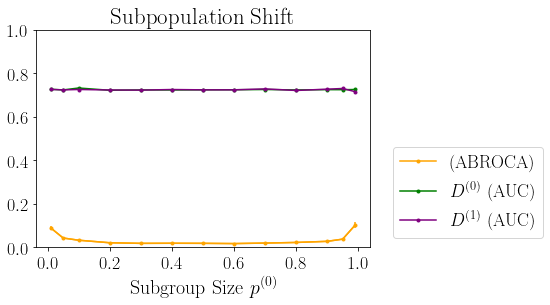

In [18]:
# sample imbalance vs. ABROCA plot example
p0 = [.01,.05,.1,.2,.3,.4,.5,.6,.7,.8,.9,.95,.99]
n = 10000
r = 100
s = 7
title = 'Subpopulation Shift'

avg_abrocas, errors, avg_g0_aucs, avg_g1_aucs = ABROCAvs_plot_new('p_0', p0, s=s, n=n, r=r, reg_type='logistic')
plt.xscale('linear')
plt.yscale('linear')
plt.plot(p0, avg_abrocas, marker='.', color='orange', label='(ABROCA)')
plt.errorbar(p0, avg_abrocas, yerr=2*errors, color='orange')
plt.plot(p0, avg_g0_aucs, marker='.', color='green', label=r'$D^{(0)}$ (AUC)')
plt.plot(p0, avg_g1_aucs, marker='.', color='purple', label=r'$D^{(1)}$ (AUC)')

plt.xlabel('Subgroup Size $p^{(0)}$')
# plt.ylabel('ABROCA')
plt.ylim([0,1])
plt.title(title)
plt.legend(bbox_to_anchor=(1.04,0), loc="lower left")
plt.savefig(f'figures/AUC_{title}(n={n},r={r},s={s}){datetime.now()}.pdf', bbox_inches="tight")
plt.show()

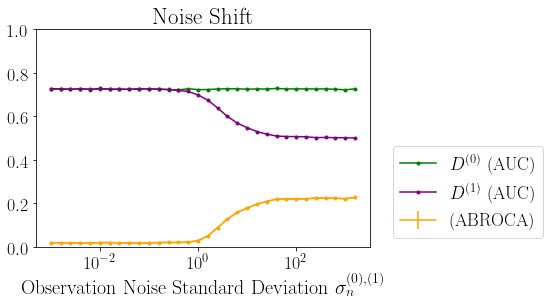

In [19]:
# observation noise vs. ABROCA plot example
eta_sds = [10**i for i in np.arange(-3,3.4,0.2)]
n = 10000
r = 100
s = 7
title = 'Noise Shift'

avg_abrocas, errors, avg_g0_aucs, avg_g1_aucs = ABROCAvs_plot_new('obs_noise', eta_sds, s=s, n=n, r=r, reg_type='logistic')
plt.xscale('log')
plt.yscale('linear')
plt.plot(eta_sds, avg_abrocas, marker='.', color='orange')
plt.errorbar(eta_sds, avg_abrocas, yerr=2*errors, color='orange', label='(ABROCA)')
plt.plot(eta_sds, avg_g0_aucs, marker='.', color='green', label=r'$D^{(0)}$ (AUC)')
plt.plot(eta_sds, avg_g1_aucs, marker='.', color='purple', label=r'$D^{(1)}$ (AUC)')

plt.xlabel(r'Observation Noise Standard Deviation $\sigma_n^{(0), (1)}$')
# plt.ylabel('ABROCA')
plt.ylim([0,1])
plt.title(title)
plt.legend(bbox_to_anchor=(1.04,0), loc="lower left")
plt.savefig(f'figures/AUC_{title}(n={n},r={r},s={s}){datetime.now()}.pdf', bbox_inches="tight")
plt.show()

/Users/nswinger/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


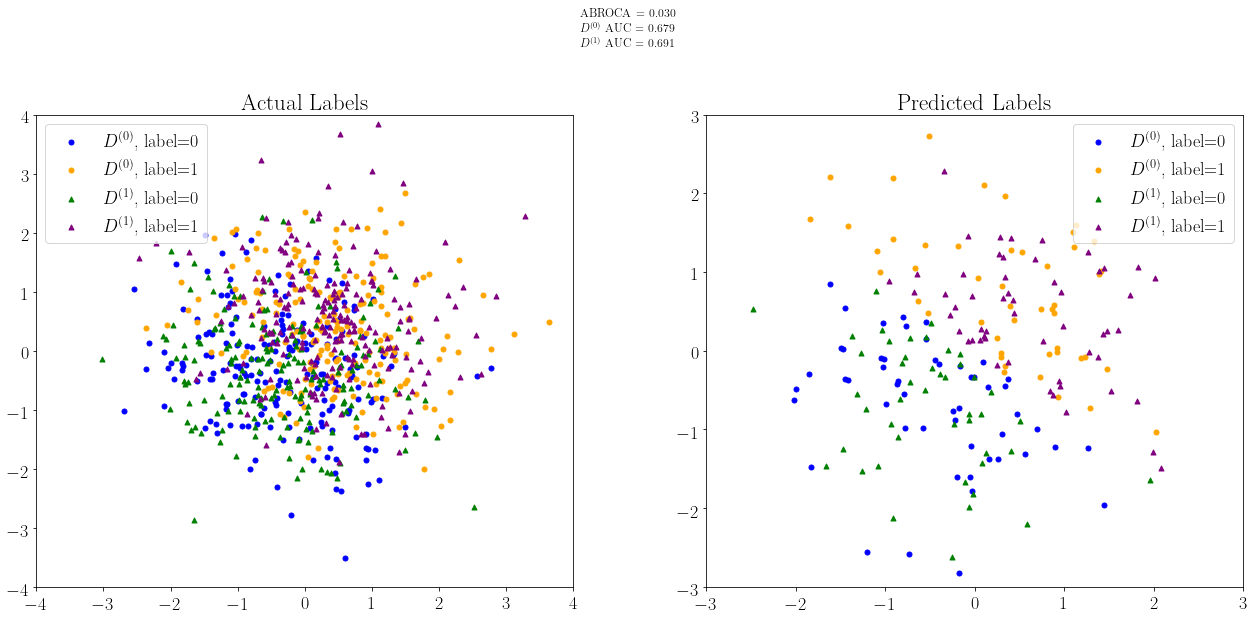

In [31]:
def visualize_data(point_size=.5, group_switch=2, s=0, figsize=(20, 10), **kwargs):
    np.random.seed(s)
    
    dflts = SimulationParams(**kwargs)
    dflts1 = SimulationParams(n=kwargs['n'])
    X_t, y_t = simulate(dflts1) # cell acts like old code if X_train, y_train = simulate(dflts), new code if X_train, y_train = simulate(dflts1)
    X, y = simulate(dflts)
            
    n_0 = int(round(dflts.n * dflts.p_0))
    _, X_test_0, _, y_test_0 = train_test_split(X[:n_0], y[:n_0], test_size=0.2, random_state=0)
    _, X_test_1, _, y_test_1 = train_test_split(X[n_0:], y[n_0:], test_size=0.2, random_state=0)
    
    X_train_0, _, y_train_0, _ = train_test_split(X_t[:n_0], y_t[:n_0], test_size=0.2, random_state=0)
    X_train_1, _, y_train_1, _ = train_test_split(X_t[n_0:], y_t[n_0:], test_size=0.2, random_state=0)
    X_train = np.append(X_train_0, X_train_1, axis=0)
    y_train = np.append(y_train_0, y_train_1, axis=0)
    X_train_0, _, y_train_0, _ = train_test_split(X[:n_0], y[:n_0], test_size=0.2, random_state=0)
    X_train_1, _, y_train_1, _ = train_test_split(X[n_0:], y[n_0:], test_size=0.2, random_state=0)
    
    plot_x0_0 = [a for a, b in zip(X_train_0[:, 0], y_train_0) if b == 0]
    plot_y0_0 = [a for a, b in zip(X_train_0[:, 1], y_train_0) if b == 0]
    plot_x0_1 = [a for a, b in zip(X_train_0[:, 0], y_train_0) if b == 1]
    plot_y0_1 = [a for a, b in zip(X_train_0[:, 1], y_train_0) if b == 1]
    plot_x1_0 = [a for a, b in zip(X_train_1[:, 0], y_train_1) if b == 0]
    plot_y1_0 = [a for a, b in zip(X_train_1[:, 1], y_train_1) if b == 0]
    plot_x1_1 = [a for a, b in zip(X_train_1[:, 0], y_train_1) if b == 1]
    plot_y1_1 = [a for a, b in zip(X_train_1[:, 1], y_train_1) if b == 1]

    

    perm = np.random.permutation(len(y_train))
    regressor = MLPClassifier(hidden_layer_sizes=(32,32), learning_rate_init=1e-4, batch_size=128, max_iter=200, random_state=0)
#     regressor = LogisticRegressionCV(cv=5)
    regressor.fit(X_train[perm], y_train[perm])

    y_pred_0 = regressor.predict(X_test_0)
    y_pred_1 = regressor.predict(X_test_1)
    
    plot_x0_0_test = [a for a, b in zip(X_test_0[:, 0], y_pred_0) if b == 0]
    plot_y0_0_test = [a for a, b in zip(X_test_0[:, 1], y_pred_0) if b == 0]
    plot_x0_1_test = [a for a, b in zip(X_test_0[:, 0], y_pred_0) if b == 1]
    plot_y0_1_test = [a for a, b in zip(X_test_0[:, 1], y_pred_0) if b == 1]
    plot_x1_0_test = [a for a, b in zip(X_test_1[:, 0], y_pred_1) if b == 0]
    plot_y1_0_test = [a for a, b in zip(X_test_1[:, 1], y_pred_1) if b == 0]
    plot_x1_1_test = [a for a, b in zip(X_test_1[:, 0], y_pred_1) if b == 1]
    plot_y1_1_test = [a for a, b in zip(X_test_1[:, 1], y_pred_1) if b == 1]


    fpr_0, tpr_0, _ = roc_curve(y_test_0, y_pred_0)
    fpr_1, tpr_1, _ = roc_curve(y_test_1, y_pred_1)
    g0auc = auc(fpr_0, tpr_0)
    g1auc = auc(fpr_1, tpr_1)
    abroca = compute_abroca(fpr_0, tpr_0, fpr_1, tpr_1)

    fig, axs = plt.subplots(1, 2, figsize=figsize)
    d0 = r'$D^{(0)}$'
    d1 = r'$D^{(1)}$'
    
    if group_switch != 1:
        axs[0].scatter(plot_x0_0, plot_y0_0, color='blue', s=point_size, label=f'{d0}, label=0', marker='o')
        axs[0].scatter(plot_x0_1, plot_y0_1, color='orange', s=point_size,
                          label=f'{d0}, label=1', marker='o')
    if group_switch != 0:
        axs[0].scatter(plot_x1_0, plot_y1_0, color='green', s=point_size, label=f'{d1}, label=0', marker='^')
        axs[0].scatter(plot_x1_1, plot_y1_1, color='purple', s=point_size,
                          label=f'{d1}, label=1', marker='^')
    axs[0].legend()
    axs[0].set_title('Actual Labels')

    axs[1].scatter(plot_x0_0_test, plot_y0_0_test, color='blue', s=point_size, label=f'{d0}, label=0', marker='o')
    axs[1].scatter(plot_x0_1_test, plot_y0_1_test, color='orange', s=point_size,
                      label=f'{d0}, label=1', marker='o')
    axs[1].scatter(plot_x1_0_test, plot_y1_0_test, color='green', s=point_size, label=f'{d1}, label=0', marker='^')
    axs[1].scatter(plot_x1_1_test, plot_y1_1_test, color='purple', s=point_size,
                      label=f'{d1}, label=1', marker='^')
    axs[1].legend()
    axs[1].set_title('Predicted Labels')

    xlim = [int(min(plot_x0_0 + plot_x0_1 + plot_x1_0 + plot_x1_1)) - 1,
            int(max(plot_x0_0 + plot_x0_1 + plot_x1_0 + plot_x1_1)) + 1]
    ylim = [int(min(plot_y0_0 + plot_y0_1 + plot_y1_0 + plot_y1_1)) - 1,
            int(max(plot_y0_0 + plot_y0_1 + plot_y1_0 + plot_y1_1)) + 1]
    
    xlim_test = [int(min(plot_x0_0_test + plot_x0_1_test + plot_x1_0_test + plot_x1_1_test)) - 1,
            int(max(plot_x0_0_test + plot_x0_1_test + plot_x1_0_test + plot_x1_1_test)) + 1]
    ylim_test = [int(min(plot_y0_0_test + plot_y0_1_test + plot_y1_0_test + plot_y1_1_test)) - 1,
            int(max(plot_y0_0_test + plot_y0_1_test + plot_y1_0_test + plot_y1_1_test)) + 1]
    
    axs[0].set_xlim(xlim)
    axs[1].set_xlim(xlim_test)
    axs[0].set_ylim(ylim)
    axs[1].set_ylim(ylim_test)
    
    fig.suptitle(f'ABROCA = {abroca:.3f}\n{d0} AUC = {g0auc:.3f}\n{d1} AUC = {g1auc:.3f}')
    fig.tight_layout(pad=10.0)

    return fig


    
e=100
g = 2
fig = visualize_data(point_size=25, group_switch=g, s=13, n=1000)
# fig = visualize_data(point_size=25, group_switch=g, s=13, n=1000, theta_1=[1*e*4,1*e*4])
fig.show()
fig.savefig(f'figures/viz_ML_noshift{datetime.now()}.pdf', bbox_inches="tight")
